# Example Seurat to Scanpy Conversion

This notebook shows a simple example of how a Seurat object can easily be converted to AnnData using Seurat's `convert()` functionality and [`anndata2ri`](https://github.com/flying-sheep/anndata2ri), a cool package developed by Phil Angerer.

In [1]:
import scanpy as sc
import numpy as np


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

/tmp/ipykernel_1785692/1522958795.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         10.0.1
anndata2ri                  1.3.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.1
cloudpickle                 2.1.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2022.7.1
dateutil                    2.8.2
debugpy                     1.6.0
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.5.0
google                      NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.9.11
ipykernel                   6.15.0
ipython_genutils            0.2.0
ipywidgets                  7.7.1
jedi                        0.18.1
jinja2 

## Scanpy

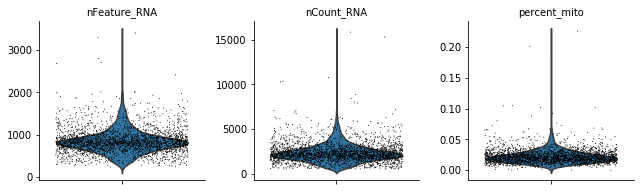

In [7]:
mito_genes = pbmc_sce.var_names.str.startswith('MT-')
pbmc_sce.obs['percent_mito'] = np.sum(pbmc_sce[:, mito_genes].X, axis=1).A1 / np.sum(pbmc_sce.X, axis=1).A1

sc.pl.violin(pbmc_sce, ['nFeature_RNA', 'nCount_RNA', 'percent_mito'], jitter=0.4, multi_panel=True)

In [ ]:
### Doublets
%matplotlib inline
import scrublet as scr

scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

In [ ]:
scrub.plot_histogram()

In [ ]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

In [ ]:
scrub.plot_embedding('UMAP', order_points=True)

In [ ]:
adata.obs['predicted_doublets'] = predicted_doublets
adata.obs['doublet_scores'] = doublet_scores

In [ ]:
adata.obs

### Count based QC

To remove barcodes that correspond to broken or no cells, we can filter cells by a minimum number of genes. For scRNAseq a minum of `200` genes is a reasonable threshold. Similarly, genes that are not or barely expressed in any  cells are not useful for the analysis.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata.obs

In [ ]:
adata.var

Broken or dying cells can also be detected by a high amount of mitochondrial genes. Mitochondrial mouse genes names start with `mt-` and human with `MT-`. We can specify a flag in `.var` entries for mitochondrial genes:

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
adata.var

In [ ]:
adata.var[ adata.var['mt']]

This flag for mitochondrial genes can then be used to compute the percentage of mitochdondrial genes per cell when given as parameter to `calculate_qc_metrics`. `calculate_qc_metrics` will also compute the number of genes and total counts per cell.

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

`calculate_qc_metrics` computes both metrics for each gene and for each cell

In [ ]:
adata.var

In [ ]:
adata.obs

Violin-plots are useful for inspecting the distribution of gene counts and total counts per cell and specifying thresholds. 

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

To see how totals and gene counts or the percentage of mitochondrial genes relate to each other, we can look at scatter plots.

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Overall, mitochondrial counts are very low. Here use can use a low default of `5` percent. In addition, to the scrublet based doublet filtering, we can also remove barcodes with very high counts.

In [ ]:
adata

For filtering, you can subset the anndata object like this:

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [ ]:
adata

## Normalization

Before computing embeddings and clusterings of cells, we normalize each cell to a total of 10,000 counts.

In [ ]:
adata.X.todense()

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
adata.X.todense()

Often data is more comparable in log-scale

In [ ]:
sc.pp.log1p(adata)

In [ ]:
adata.X.todense()

As we will apply further scaling downstream, we will store the log-normalized counts in `adata.raw`. We can restore them with `adata.raw.to_adata()`.

In [ ]:
adata.raw = adata

## Variable genes

In order to compute embeddings and clusterings of our data, we first perform principal component analysis (PCA) for dimensionality reduction. A PCA is often more informative when the data set is limited to variable genes. `highly_variable_genes` offers different `flavors` for identifying highly variable genes; here we are using the default `seurat` style. see https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html for more details. 

In [ ]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

In [ ]:
sc.pl.highly_variable_genes(adata)

In addition, to log-normalizing data it should be scaled before computing a PCA

In [ ]:
sc.pp.scale(adata, max_value=10)

For computing the PCA, we specify that we are limiting it to highly variable genes and give the number of PCs to be computed 

In [ ]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

The loadings of the PCs suggest genes which explain high variance among the single cell data

In [ ]:
sc.pl.pca_loadings(adata, include_lowest=False)

In [ ]:
sc.pl.pca_loadings(adata, components='4,5,6', include_lowest=False)

In [ ]:
sc.pl.pca(adata, color=['C1qb', 'Mobp'])

For downstream steps such as computing embeddings and clusterings, we should limit the number of PCs. Using an elbow plot we can determine the PCs that show a high contribution to variance in our data. The first 37 PCs look like a reasonable choice.

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Embeddings

To visualize single cell data in two dimensions, UMAP and tSNE are very useful embeddings. A UMAP uses a neighborhood graph that is computed based on PCs. This neighborhood graph will also be used for Leiden clustering.

In [ ]:
sc.pp.neighbors(adata, n_pcs=37)

In [ ]:
sc.tl.umap(adata)

On the UMAP we can that the genes with the highest loadings for the first 3 PCs are associated with distinct clusters.

In [ ]:
sc.pl.umap(adata, color=['C1qb', 'Mobp', 'Atp1a2'])

Alternatively, we can compute a tSNE to visualize single cell data in 2D. Although UMAPs are generally better for capturing relationships between data points. tSNEs can provide a good view on distinct clusters.

In [ ]:
sc.tl.tsne(adata, n_pcs=37)

In [ ]:
sc.pl.tsne(adata, color=['C1qb', 'Mobp', 'Atp1a2'], use_raw=False)

UMAPs (or tSNEs) can also be useful to inspect biases in the data such as low and high counts, or where doublets are located. 

In [ ]:
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'doublet_scores'], use_raw=False)

The coordinates of embeddings are stored in `.obsm` entries

In [ ]:
adata.obsm

In [ ]:
adata.obsm['X_umap']

In [ ]:
adata.obsm['X_umap'].shape

### Clustering

Using the neighborhood graph that we computed above with `sc.pp.neighbors`, we can perform Leiden clustering to group single cells. This will be useful for identifying cell types. For Leiden clustering, a clustering resolution can be specified where higher values will result in more clusters.

In [ ]:
sc.tl.leiden(adata, resolution=0.3)

Per default Leiden clustering is saved as `leiden` entry in `.obs`.

In [ ]:
sc.pl.umap(adata, color=['leiden'])

Most of time, different clustering resolutions should be inspected depending on how fine or coarse grained the clustering of cells should be. We can automate this by looping over different resolutions and adding a key for each clustering resolution.

In [ ]:
resolutions = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3]

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added='leiden_' + str(res) )

In [ ]:
adata.obs

In [ ]:
sc.pl.umap(adata, color=['leiden_2', 'Gad2', 'Slc17a6'])

In [ ]:
sc.pl.umap(adata, color=['leiden_0.3', 'Gad2', 'Slc17a6'])

### Removing doublet clusters

Rather than just removing doublets seperately based on a threshold, it can be useful to remove clusters with a high doublet fraction. This way we also capture cells that would just be above a doublet threshold.

In [ ]:
adata.obs['str_predicted_doublets'] = [str(dbl) for dbl in adata.obs['predicted_doublets']]
sc.pl.umap(adata, color=['str_predicted_doublets', 'leiden_2'])

Sometimes it is easier to plot the cluster IDs on the UMAP directly

In [ ]:
sc.pl.umap(adata, color=['str_predicted_doublets', 'leiden_2'], legend_loc='on data')

We can compute the fraction of doublets for each cluster using a rather high clustering resolution. This fraction can then be used to clean up our data before computing marker genes.

In [ ]:
# what is fraction of doublets per cluster
import numpy as np
import pandas as pd

# init lists
list_clusters = np.unique(adata.obs['leiden_2'])
list_size = []
list_frac_doublets = []

# loop over clusters
for clus in list_clusters:
    clus_adata = adata[adata.obs['leiden_2'] == clus]
    
    size = clus_adata.shape[0]
    n_doublets = sum( clus_adata.obs['predicted_doublets'])
    
    list_frac_doublets.append( n_doublets / size )
    list_size.append(size)
    
df_frac_doublets = pd.DataFrame(
{
    'cluster': list_clusters,
    'size': list_size,
    'frac_doublets': list_frac_doublets
}
)

For a relatively strict filtering of doublet clusters, we could remove all clusters with a fraction of at least `0.3` doublets.

In [ ]:
df_frac_doublets.sort_values('frac_doublets', ascending=False)

We store the doublet cluster IDs in a list that we can use for filtering 

In [ ]:
doublet_clusters = [ clus for clus 
                    in df_frac_doublets[ df_frac_doublets['frac_doublets'] >= 0.3 ]['cluster'] ]
doublet_clusters

In [ ]:
adata

You can remove the doublet clusters and doublet by subsessting the anndata object

In [ ]:
adata = adata[ ~adata.obs['leiden_2'].isin(doublet_clusters) ].copy()
adata = adata[ adata.obs['predicted_doublets'] == False ].copy()
adata

After removing doublets and clusters, the clusters should be recomputed

In [ ]:
resolutions = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3]

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added='leiden_' + str(res) )

In [ ]:
sc.pl.umap(adata, color=['leiden_0.3'])

### Marker genes

Now that we cleaned up our single cell data, we can start computing marker genes for clusters to help us understand their characteristics. This is also useful for annotating them for example as different cell types. Marker genes are computed with `sc.tl.rank_genes_groups`. The second argument specifies the clustering or annotation for which we compute. Here we use the Leiden clustering with resolution 0.3 `leiden_0.3`. We also specify the key for storing the clustering `key_added`. SCANPY offer different ways for computing marker genes. Per default we collect all cells from one cluster and compare them against all other cells. Methods for detecting marker genes are:
- `t-test`: t-test
- `wilcoxon`: Wilcoxon-ranksum test. This test usually works well on single cell data
- `logreg`: logistic regression (computational more demanding)
For more details see: 
https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html

`sc.pl.rank_genes_groups` can be used for plotting the top marker genes per cluster. 

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_0.3', method='wilcoxon', use_raw=True, key_added='rank_leiden_0.3')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='rank_leiden_0.3')

Marker genes and associated statistics are stored in `.uns`. In this case, `rank_leiden_0.3`.

In [ ]:
adata

In [ ]:
adata.uns['rank_leiden_0.3'].keys()

A simple way to obtain the marker genes of a cluster as a pandas data frame is `sc.get.rank_genes_groups_df`

In [ ]:
df_ranked_genes = sc.get.rank_genes_groups_df(adata, '0', key='rank_leiden_0.3')
df_ranked_genes

This data frame can be saved and used for further analysis like enrichment analysis for differentially expressed genes (DEGs), which are explained in other tutorials of this course in more detail. 

In [ ]:
outf = outdir + "/marker_cluster0_rank_leiden_0.3.tsv"
df_ranked_genes.to_csv(outf, sep="\t", index=None)
print(outf)

Let's check the expression of the top marker genes on the UMAP

In [ ]:
sc.pl.umap(adata, color=['Plp1', 'Edil3', 'leiden_0.3'], legend_loc='on data')

While Plp1 is very specifically expressed in cluster `0`. `Edil3` also shows expression outside of cluster `0`. In addition some genes may show a high log-fold change but are barely expressed anywhere. For a more strict filtering of marker genes, we can use `sc.tl.filter_rank_genes_groups`. Here `min_in_group_fraction` specifies a threshold for the fraction of cells that express the marker in the cluster and `max_out_group_fraction` outside of the clusters. We can also set an additional threshold for the log-fold change here `min_fold_change`. For example, if we set `max_out_group_fraction=0.5` we will keep the top marker gene `Plp1` but label the second best `Edil3` as `nan`.

In [ ]:
# sparsity
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.25,
    max_out_group_fraction=0.5,
    min_fold_change=2,
    key="rank_leiden_0.3",
    key_added="rank_leiden_0.3_filtered",
)


In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='rank_leiden_0.3_filtered')

As quick way to obtain insights into biological processes, SCANPY offers a wrapper `sc.queries.enrich` for gprofiler (https://biit.cs.ut.ee/gprofiler/gost). Here, we give it a set of genes and specify the species we are looking at: `mmusculus` for mouse and `hsapiens` for human.

In [ ]:
df_rank_cur_cluster = sc.get.rank_genes_groups_df(adata, '0', key='rank_leiden_0.3_filtered', 
                                                  log2fc_min=2, pval_cutoff=0.05)
sel_genes = [ gene for gene in df_rank_cur_cluster.dropna()['names'] ]
sc.queries.enrich( sel_genes, org='mmusculus').head(n=10)

In [ ]:
df_rank_cur_cluster = sc.get.rank_genes_groups_df(adata, '1', key='rank_leiden_0.3_filtered', 
                                                  log2fc_min=1, pval_cutoff=0.05)
sel_genes = [ gene for gene in df_rank_cur_cluster.dropna()['names'] ]
sc.queries.enrich( sel_genes, org='mmusculus').head(n=10)

For more specific comparisions, we can specify the foreground clusters `groups` to be tested and the background clusters as `ref`. For example, for a pair-wise test betwenn cluster `7` and cluster `6`:

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_0.3', groups=[7], ref=[6], method='wilcoxon', 
                        use_raw=True, key_added='rank_selgroups_leiden_0.3')

In [ ]:
sc.get.rank_genes_groups_df(adata, '7', key='rank_selgroups_leiden_0.3', 
                                                  log2fc_min=1, pval_cutoff=0.05)

### Annotating celltypes
Distinct clusters in single cell data usually corresponds to cell types, subclasses of cell types, or, cell states depending on the clustering resolution.

Annotating cell types in single cell data usually requires knowledge of cell type specific marker genes or comparison to related already annotated data sets.

If related annotated data sets exist, automated annotation tools can be useful, for example:
- ingest: https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html
- scanvi (should be run on a GPU): https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html

However, it is still important to manually verify the expression of key marker genes which usually involves literature research or knowledge of marker genes. Here, we will briefly outline the old-fashioned way for annotating single cell clusters

For cluster `0`, we already know from gene enrichment analysis that likely corresponds to a celltype involved in mylenation of axons. In addition, the top marker gene of cluster `0` is `Plp1` a known marker gene for oligodendrocytes.

For non-neuronal cell types, we know following marker genes:
- `Plp1`: oligodendrocytes
- `Aqp4`: astrocytes
- `Csfr1`: microglia 
- `Flt1`: also known as VEGFR-1 vascular endothelial celltypes

For less simple cases, especially when looking at subclasses, combinations of expressed genes and the absence of the expression of specific genes is often useful for annotating them.

In [ ]:
sc.pl.umap(adata, color=['Plp1', 'Aqp4', 'Csf1r', 'Flt1'], cmap='inferno', legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['leiden_0.3'], legend_loc='on data')

We can store these cell type mappings in dictionary:

In [ ]:
dict_annotate_clusters = {
    '0': 'oligodendrocyte',
    '5': 'astrocyte',
    '6': 'microglia',
    '18': 'vascular'
}

This dictionary can then be used to add an annotation as `.obs` entry. Clusters which we didn't annotate yet, we simply call `unknown_cluster` + the cluster ID:

In [ ]:
[ cluster for cluster in adata.obs['leiden_0.3']]

In [ ]:
adata.obs['celltype'] = [ dict_annotate_clusters[cluster] if cluster in dict_annotate_clusters.keys()
                        else 'unknown_cluster' + cluster
                        for cluster in adata.obs['leiden_0.3'] ]

In [ ]:
dict_annotate_clusters['0']

In [ ]:
sc.pl.umap(adata, color=['celltype'], legend_loc='on data')

### TASK: 

MGE interneurons can be identified by `Pvalb` and `Sst` gene expression while `Vip` is a gene characteristic to CGE interneurons.
    
1. Which clusters correspond to MGE and which to CGE interneurons? 
2. What are the top two differentially expressed genes for each cluster based based on pair-wise comparison ?
3. Visualize the expression of the top two genes for the MGE and CGE interneurons cluster